In [2]:
import sys
import os
from pprint import pprint
from tqdm import tqdm
import threading

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [6]:
#folder="D:\\Data\\london_smartmeter\\dataset_kaggle\\"
folder="../input/"
folder_data_block="../input/"

In [4]:
file='weather_daily_darksky.csv'#don't understand the loqdinf fqiling for the csv
df_weather_daily=pd.read_csv(folder+file)
df_weather_daily["time"]=pd.to_datetime(df_weather_daily["time"])
df_weather_daily=df_weather_daily.sort_values(["time"])
df_weather_daily["day"]=df_weather_daily.apply(lambda row:row["time"].strftime("%Y-%m-%d"),axis=1)
df_weather_daily["temperatureMean"]=df_weather_daily.apply(lambda row:(row["temperatureMax"]+row["temperatureMin"])/2,axis=1)
df_weather_daily=df_weather_daily.drop_duplicates(["day"])
df_weather_daily=df_weather_daily.set_index(("day"))
df_weather_daily.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase,temperatureMean
day,,,,,,,,,,,,,,,,,,,,,
2011-11-01,15.57,2011-11-01 15:00:00,208,partly-cloudy-day,10.13,2011-11-01 22:00:00,0.36,2.45,1009.46,2011-11-01 22:00:00,...,2011-11-01 06:54:29,2011-11-01 15:00:00,2011-11-01 10:00:00,Partly cloudy until evening.,2011-11-02 03:00:00,9.01,2011-11-01 15:00:00,2011-11-02 03:00:00,0.21,12.625
2011-11-02,15.19,2011-11-02 23:00:00,134,partly-cloudy-night,10.23,2011-11-02 03:00:00,0.39,4.39,1004.79,2011-11-02 03:00:00,...,2011-11-02 06:56:16,2011-11-02 13:00:00,2011-11-02 09:00:00,Partly cloudy throughout the day.,2011-11-02 19:00:00,7.33,2011-11-02 23:00:00,2011-11-02 19:00:00,0.24,12.035
2011-11-03,17.41,2011-11-03 14:00:00,154,partly-cloudy-day,13.39,2011-11-03 21:00:00,0.52,3.99,993.40,2011-11-03 21:00:00,...,2011-11-03 06:58:03,2011-11-03 14:00:00,2011-11-03 10:00:00,Partly cloudy throughout the day.,2011-11-04 07:00:00,12.79,2011-11-03 14:00:00,2011-11-04 07:00:00,0.27,15.100
2011-11-04,15.54,2011-11-04 11:00:00,179,fog,12.03,2011-11-04 23:00:00,0.50,2.62,995.54,2011-11-04 23:00:00,...,2011-11-04 06:59:49,2011-11-04 11:00:00,2011-11-04 10:00:00,Foggy overnight.,2011-11-05 02:00:00,11.53,2011-11-04 11:00:00,2011-11-05 02:00:00,0.31,13.535
2011-11-05,13.94,2011-11-05 15:00:00,346,fog,10.96,2011-11-05 02:00:00,0.65,2.70,1007.39,2011-11-05 02:00:00,...,2011-11-05 07:01:36,2011-11-05 15:00:00,2011-11-05 10:00:00,Foggy in the morning.,2011-11-06 05:00:00,10.17,2011-11-05 15:00:00,2011-11-06 06:00:00,0.34,12.055


### Half Hourly Data

In [10]:
# Works on the first file
file='block_0.csv'
df_block=pd.read_csv("../input/halfhourly_dataset/"+file)
df_block["tstp"]=pd.to_datetime(df_block["tstp"])
df_block["energy(kWh/hh)"]=pd.to_numeric(df_block["energy(kWh/hh)"],errors="coerce")
df_block=df_block.dropna()
df_block.head()

,LCLid,tstp,energy(kWh/hh)
0,MAC000002,2012-10-12 00:30:00,0.0
1,MAC000002,2012-10-12 01:00:00,0.0
2,MAC000002,2012-10-12 01:30:00,0.0
3,MAC000002,2012-10-12 02:00:00,0.0
4,MAC000002,2012-10-12 02:30:00,0.0


In [11]:
get_householdid=list(df_block["LCLid"].unique())

In [12]:
# Function to collect and analyse the data from one household
aggregation={
    "energy(kWh/hh)":{
        "min_energy":"min",
        "mean_energy":"mean",
        "max_energy":"max",
        "sum_energy":"sum",
        "count":"count"
    },
    "weekday":"first",
    "month":"first",
    "type_month":"first"  
}

def get_df_household(df_household):
    df_household["weekday"]=df_household.apply(lambda row:row["tstp"].weekday(),axis=1)
    df_household["day"]=df_household.apply(lambda row:row["tstp"].strftime("%Y-%m-%d"),axis=1)
    df_household["month"]=df_household.apply(lambda row:row["tstp"].strftime("%Y-%m"),axis=1)
    df_household["type_month"]=df_household.apply(lambda row:int(row["tstp"].strftime("%m")),axis=1)
    return df_household

def analyse_df_household(df_household):
    df_household=get_df_household(df_household)
    df_count=df_household.groupby(["day"]).agg(aggregation)
    df_cross=pd.concat([df_count,df_weather_daily],axis=1, join_axes=[df_count.index])
    return df_cross

In [13]:
#Works on a subset of the first block
dict_result={}
for household in tqdm(get_householdid[:10]):
    df_household=df_block[df_block["LCLid"]==household]
    df_cross=analyse_df_household(df_household)
    df_cross=df_cross.reset_index()
    df_cross["LCLid"]=[household]*len(df_cross)
    dict_result[household]=df_cross

  0%|          | 0/10 [00:00<?, ?it/s]/home/walle/.virtualenvs/pytorch_ts_py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/walle/.virtualenvs/pytorch_ts_py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/walle/.virtualenvs/pytorch_ts_py36/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

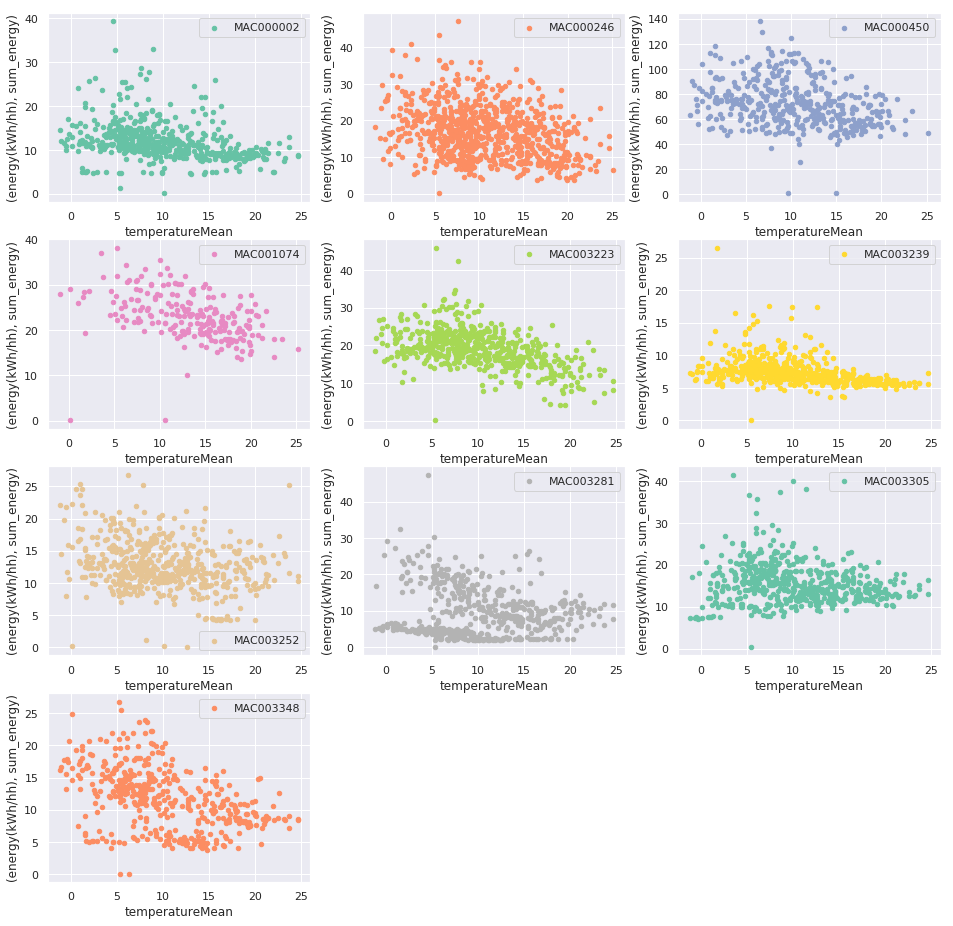

In [15]:
# Make a plot to illustrathe the different behaviour for the first 10 housrholds in the first block file
fig,ax=plt.subplots(figsize=(16,16))
palette=sns.color_palette("Set2", len(list(dict_result.keys())))
for i,household in enumerate(dict_result):
    ax=plt.subplot(4,3,i+1)
    dict_result[household].plot(ax=ax,x="temperatureMean",y=('energy(kWh/hh)', 'sum_energy'),kind="scatter",color=palette[i],label=household)
plt.legend()
plt.show()

**Notes**: This figure illusrates the difference of daily energy usage in function of the outdoor temperature. The second household ( MAC000003) is clearly using the elelctricity as a source of heating during the winter.